# IMPLEMENTEZ UN MODELE DE SCORING

# Feature selection et gestion du déséquilibre des classes

### Contexte

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

### Missions
- **Mission 1: Construction d'un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.**
- **Mission 2: Construction d'un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.**
- **Mission 3: Mise en production du modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif appelant l’API pour les prédictions.**

### Notebook réalisé à la manière de mon mentor expert métier
- **Feature selection via RFE-CV**: Cette dernière sera réalisée sur un Random Forest Classifier non optimisé.
- **Optimisation du Random Forest Classifier**: Si un modèle présentant de meilleures performances est obtenu, ce dernier sera retenu pour trouver la meilleure stratégie pour la gestion du déséquilibre des classes.
- **Gestion du déséquilibre des classes**: Test de SMOTE, d'un oversampling, d'un undersampling et d'une attribution manuelle du poids à accorder à la classe minoritaire.

### A noter: Les modèles seront entraînés 2 fois
- **Premier entraînement**: Analyse des résultats en tenant compte des meilleurs scores métiers obtenus application du seuil optimal, ce qui est NOTRE METRIQUE (MLFlow ne permettant pas forcément la visualisation directe de certains paramètres).
- **Deuxième entraînement**: Analyse plus approfondie des stratégies les plus prometteuses.
- **ATTENTION**: Le Random Forest classifier n'est utilisé que pour la gestion du déséquilibre des classes. Les différentes modélisations seront réalisées dans le prochain notebook.

In [1]:
# Import des librairies classiques

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import os

# Import des librairies pour le ML
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Import des librairies pour le scoring et le tracking
from sklearn.metrics import make_scorer
from sklearn import metrics
import mlflow
import mlflow.sklearn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## LES FONCTIONS

### 1. Le score métier

**Concernant le score métier, il nous a été suggéré de considérer qu'un faux négatif (FN) est 10 fois supérieur au coût d’un faux positif (FP).**

In [2]:
def score_metier(y_true, y_pred):
    
    '''
    Fonction permettant de définir le score métier
    ----------------------------------------------
    - Retourne un score compris entre 0 et 1
    - Meilleur score = 0
    - Pire Score =1
    '''
    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_pred).ravel()
    return (10*fn + fp)/ sum([tn, fp,10*fn, tp])

scorer_metier = make_scorer(score_metier,  greater_is_better=False)

### 2. Le seuil métier 

**L'établissement d'un seuil métier est courant dans les problèmes de classification, en particulier lorsque les coûts de faux positifs et de faux négatifs sont très différents. Par défaut, le seuil est de 0,5 pour une classification binaire : si la probabilité prédite d'appartenir à la classe positive est supérieure à 0,5, la prédiction est positive, sinon elle est négative.**

In [3]:
def business_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_pred).ravel()
    return (10*fn + fp) / sum([tn, fp, 10*fn, tp])

def seuil_metier(model, X_train, y_train, thresholds):
    
    '''Recherche du meilleur seuil via l'utilisation du score métier.'''
    
    y_probs = model.predict_proba(X_train)[:, 1]
    
    best_score = float('inf')
    best_threshold = 0
    scores = []
    
    for threshold in thresholds:
        y_pred = [1 if prob > threshold else 0 for prob in y_probs]
        
        # Utilisation de la fonction business_score
        score = business_score(y_train, y_pred)
        
        scores.append(score)
        
        if score < best_score:
            best_score = score
            best_threshold = threshold
            
    return best_threshold, best_score, scores

### 3. La matrice de confusion et la courbe ROC

In [4]:
def confusion_matrix_roc_auc(model, y_true, y_pred, y_pred_proba):
    
    
    '''
    Fonction permettant la visualisation de la matrice de confusion et de la courbe ROC
    -----------------------------------------------------------------------------------------
    Matrice de confusion pouvant être réalisée avec le seuil de base (0,5) ou le seuil métier
    '''
    
    fig = plt.figure(figsize=(20,15))

    # Calcul de AUC-ROC
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    # Matrice de confusion
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.title('Matrice de confusion')

    # Courbe ROC
    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label=f'AUC = {roc_auc:.4f}')
    plt.title('Courbe ROC')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.legend()
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')  # ligne de référence pour un modèle aléatoire

    plt.tight_layout()
    plt.show()

### 4. La fonction pour le tracking via MLFLOW

In [5]:
def business_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_pred).ravel()
    return (10 * fn + fp) / (tn + fp + 10 * fn + tp)

def seuil_metier(model, X, y, thresholds):
    y_probs = model.predict_proba(X)[:, 1]
    best_score = float('inf')
    best_threshold = 0
    scores = []
    
    for threshold in thresholds:
        y_pred = [1 if prob > threshold else 0 for prob in y_probs]
        score = business_score(y, y_pred)
        scores.append(score)
        
        if score < best_score:
            best_score = score
            best_threshold = threshold
            
    return best_threshold, best_score, scores

def mlflow_tracking(model, X_train, X_test, y_train, y_test, thresholds=np.linspace(0, 1, 100)):
    
    # Obtention du nombre de variables
    num_features = X_train.shape[1]
    
    # Nom du projet :
    mlflow.set_experiment('Projet7_Imbalanced_Targets')

    with mlflow.start_run() as run:
        name = str(model).split('(')[0]
        mlflow.set_tag("mlflow.runName", datetime.datetime.today().strftime('%Y-%m-%d') + ' - ' + str(model).split('(')[0])
        
        # Obtention du nombre de features
        mlflow.log_param("Number of Features", num_features)
        
         # Entraînement du modèle
        start_time_fit = time.time()
        model.fit(X_train, y_train)
        end_time_fit = time.time()

         # Recherche du meilleur seuil sur l'ensemble d'entraînement
        best_threshold_train, best_score_train, _ = seuil_metier(model, X_train, y_train, thresholds)

         # Prédiction sur l'ensemble de test en utilisant le seuil optimal du train 
        y_probs_test = model.predict_proba(X_test)[:, 1]
        y_pred_test_threshold = [1 if prob > best_threshold_train else 0 for prob in y_probs_test]
    
         # Prédiction sur l'ensemble d'entraînement en utilisant le seuil optimal du train 
        y_probs_train = model.predict_proba(X_train)[:, 1]
        y_pred_train_threshold = [1 if prob > best_threshold_train else 0 for prob in y_probs_train]
        
        # Enregistrement des hyperparamètres
        mlflow.log_params(model.get_params())

        # Enregistrement des métriques
         # Calcul du temps d'entraînement
        training_time = end_time_fit - start_time_fit
        mlflow.log_metric("Training Time", training_time)
        
         # Enregistrement de l'accuracy pour les jeux d'entraînement et de test avec le seuil optimal
        acc_train = round(accuracy_score(y_train, y_pred_train_threshold) * 100, 4)
        mlflow.log_metric("Train Accuracy", acc_train)
        
        acc_test = round(accuracy_score(y_test, y_pred_test_threshold) * 100, 4)
        mlflow.log_metric("Test Accuracy", acc_test)
        
         # Enregistrement de l'AUC pour les jeux d'entraînement et de test 
        y_train_proba = model.predict_proba(X_train)[:, 1]
        auc_train = round(roc_auc_score(y_train, y_train_proba), 4)
        mlflow.log_metric("Train AUC", auc_train)
        
        y_test_proba = model.predict_proba(X_test)[:, 1]
        auc_test = round(roc_auc_score(y_test, y_test_proba), 4)
        mlflow.log_metric("Test AUC", auc_test)
        
         # Enregistrement du recall pour les jeux d'entraînement et de test avec le seuil optimal
        recall_train = round(recall_score(y_train, y_pred_train_threshold), 4)
        mlflow.log_metric("Train Recall", recall_train)
        
        recall_test = round(recall_score(y_test, y_pred_test_threshold, zero_division=0), 4)
        mlflow.log_metric("Test Recall", recall_test)
        
         # Enregistrement de la précision pour les jeux d'entraînement et de test avec le seuil optimal
        precision_train = round(precision_score(y_train, y_pred_train_threshold, zero_division=0), 4)
        mlflow.log_metric("Train Precision", precision_train)
        
        precision_test = round(precision_score(y_test, y_pred_test_threshold, zero_division=0), 4)
        mlflow.log_metric("Test Precision", precision_test)
        
         # Enregistrement du score f1 pour les jeux d'entraînement et de test
        f1_train = round(f1_score(y_train, y_pred_train_threshold), 4)
        mlflow.log_metric("Train f1", f1_train)
        
        f1_test = round(f1_score(y_test, y_pred_test_threshold, zero_division=0), 4)
        mlflow.log_metric("Test f1", f1_test)
        
         # Seuil métier et meilleur score métier
        mlflow.log_metric("Train Meilleur seuil", round(best_threshold_train, 4)) 
        mlflow.log_metric("Train Meilleur score metier", round(best_score_train, 4))
        best_score_test = business_score(y_test, y_pred_test_threshold)
        mlflow.log_metric("Test Meilleur score metier",  round(best_score_test, 4))
        
         # Sauvegarde du modèle
        mlflow.sklearn.log_model(model, "model")
        
        # Fin du RUN
        mlflow.end_run()
        
        # Création d'un DataFrame avec les métriques
        metrics_dict = {
            "Model": [str(model).split('(')[0]],
            "Training Time": round(training_time, 4),
            "Train Accuracy": round(acc_train, 4),
            "Test Accuracy": round(acc_test, 4),
            "Train AUC": round(auc_train, 4),
            "Test AUC": round(auc_test,4 ),
            "Train Recall": round(recall_train ,4),
            "Test Recall": round(recall_test, 4),
            "Train Precision": round(precision_train, 4),
            "Test Precision": round(precision_test, 4),
            "Train f1": round(f1_train, 4),
            "Test f1": round(f1_test, 4),
            "Best threshold": round(best_threshold_train, 4),
            "Train best score": round(best_score_train, 4),
            "Test best score": round(best_score_test, 4)
        }

        metrics_df = pd.DataFrame(metrics_dict).T

        return metrics_df

## FEATURE SELECTION PAR RFE-CV

**La RFE-CV (Recursive Feature Elimination with Cross-Validation) est une méthode utilisée pour sélectionner les caractéristiques (features) les plus importantes d'un ensemble de données lors de la construction d'un modèle.**

Etant en possession de variables pouvant être inutiles et conduire à un certain bruit de fond, une sélection sera réalisée par une RFE-CV *via* l'utilisation d'un Random Forest Classifier avec un weight_class="balanced" (prise en compte du déséquilibre des classes).

**A NOTER:** Cette technique, prenant beaucoup de temps d'exécution, ne sera réalisée que sur un échantillon de 75000 clients avec stratification sur la target/cible.

In [6]:
# Ouverture du jeu d'entrainement
file_1 = pd.read_csv("trainset.csv", sep=',')
pd.set_option("Display.max_rows", None)
pd.set_option("Display.max_columns", None)
file_1.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,REGION_POPULATION_RELATIVE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,AGE,YEARS_LAST_PHONE_CHANGE,YEARS_EMPLOYED,FLAG_CONTACT,FLAG_DOCUMENT_SUM,ANNUITY_INCOME_PERC,ANNUITY_RATE_PERC,CREDIT_INCOME_PERC,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,"ORGANIZATION_TYPE_Commerce, finance, services et business",ORGANIZATION_TYPE_Divers,"ORGANIZATION_TYPE_Gouvernement, Securite et Services publics","ORGANIZATION_TYPE_Industrie, construction et agriculture","ORGANIZATION_TYPE_Sante, education et religion",ORGANIZATION_TYPE_Self employed,"EMPLOI_Personnel administratif, de gestion et specialise","EMPLOI_Personnel de securite, transport et logistique",EMPLOI_Personnel de vente et de service client,EMPLOI_Personnel manuel et entretien,EMPLOI_Unknown,prev_AMT_ANNUITY_mean,prev_AMT_CREDIT_mean,prev_AMT_CREDIT_sum,prev_AMT_DOWN_PAYMENT_mean,prev_DAYS_DECISION_mean,prev_CNT_PAYMENT_mean,prev_canceled,prev_refused,prev_unused_offer,prev_NAME_TYPE_SUITE,prev_NFLAG_INSURED_ON_APPROVAL,prev_AMT_PAYMENT_mean,prev_AMT_INSTALMENT_mean,prev_SK_DPD_count,home_active_sum,home_closed_sum,home_bad_debt_sum,home_sold_sum,home_DAYS_CREDIT_min,home_CREDIT_DAY_OVERDUE_mean,home_DAYS_CREDIT_ENDDATE_mean,home_DAYS_ENDDATE_FACT_min,home_CNT_CREDIT_PROLONG_sum,home_AMT_CREDIT_SUM_sum,home_AMT_CREDIT_SUM_mean,home_AMT_CREDIT_SUM_DEBT_sum,home_AMT_CREDIT_SUM_LIMIT_mean,home_AMT_CREDIT_SUM_OVERDUE_mean,home_AMT_CREDIT_MAX_OVERDUE_mean,home_AMT_ANNUITY_mean,prev_type_loans,prev_cash_loans_perc,prev_revolving_loans_perc,total_accepted_loans
0,100002,1,0,0,1,202500.0,406597.5,24700.5,0,0.018801,1.0,2,0,0,0,0.083037,0.262949,0.139376,2.0,2.0,26.0,3.0,1.7,4,1,12.197778,6.074927,200.788889,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9251.775,179055.00,179055.0,0.000000,606.000000,24.000000,0.0,0.0,0.0,-1.0,0.0,11559.247105,11559.247105,19.0,2.0,6.0,0.0,0.0,103.0,0.0,115.625,-2.0,0.0,865055.565,108131.945625,245775.0,3997.570625,0.0,1049.893125,0.0,1.0,0.0,0.0,9.0
1,100003,0,1,0,0,270000.0,1293502.5,35698.5,1,0.003541,2.0,1,0,0,0,0.311267,0.622246,-2.000000,1.0,0.0,46.0,2.0,3.3,4,1,13.221667,2.759832,479.075000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,56553.990,484191.00,1452573.0,2294.333333,1305.000000,10.000000,0.0,0.0,0.0,1.0,1.0,64754.586000,64754.586000,28.0,1.0,3.0,0.0,0.0,606.0,0.0,304.000,-2.0,0.0,1017400.500,254350.125000,0.0,202500.000000,0.0,0.000000,-2.0,3.0,33.3,0.0,7.0
2,100004,0,0,1,1,67500.0,135000.0,6750.0,0,0.010032,1.0,2,0,0,0,-2.000000,0.555912,0.729567,0.0,0.0,52.0,2.0,0.6,5,0,10.000000,5.000000,200.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5357.250,20106.00,20106.0,4860.000000,815.000000,4.000000,

In [7]:
# Copie du jeu de données
trainset = file_1.copy()

## 1. Préparation du jeu de données de 75000 clients

### 1.1. Séparation des données et création de l'échantillonnage des clients

In [8]:
# Séparation du jeu de données en X et y
X = trainset.drop(["SK_ID_CURR", "TARGET"], axis=1)
y = trainset["TARGET"]

# Echantillonnage de 4000 données
X_small, _, y_small, _ = train_test_split(X, y, train_size=75000, stratify=y, random_state=42)

# Vérification de l'échantillonnage
print(X_small.shape)  
print(y_small.shape)  

(75000, 96)
(75000,)


### 1.2 Séparation du jeu de données en jeux d'entraînement et de test 

In [9]:
# Séparation données en un ensemble d'entraînement (80%) et un ensemble de test (20%).
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_small, y_small, train_size=0.80, stratify=y_small, random_state=42)

# Vérification de la bonne séparation
print(X_train_sub.shape)  
print(y_train_sub.shape)  
print(X_test_sub.shape)   
print(y_test_sub.shape) 

(60000, 96)
(60000,)
(15000, 96)
(15000,)


### 1.3. Application du MinMaxScaler

In [10]:
# Ajustement uniquement sur les données d'entraînement (pour éviter la fuite de données)
scaler= MinMaxScaler()
scaler.fit(X_train_sub)

# Transformation des ensembles d'entraînement et de test
X_train_sub_scaled = scaler.transform(X_train_sub)
X_test_sub_scaled = scaler.transform(X_test_sub)

## 2. RFE-CV via un Random Forest Classifier sur l'échantillonnage des 750000 clients

**La RFE-CV sera réalisée avec un Random Forest Classifier avec les paramètres de base, exception faite du class_weight. En effet, étant en présence de classes déséquilibrées, il est davantage pertinent d'en tenir compte à ce stade.**

### 2.1. Initialisation du modèle et réalisation dela RFE-CV

In [11]:
'''# Initialisation du modèle et réalisation de RFE-CV

estimator = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

min_features_to_select = 1  # Conservation d'au moins une caractéristique lors de l'élimination

rfecv = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(5), 
              scoring='roc_auc', min_features_to_select=min_features_to_select) # step = 1 : Elimination d'un variable à chaque itération

# Application du RFE-CV
rfecv.fit(X_train_sub_scaled, y_train_sub)

# Visualisation des résultats
plt.figure()
plt.title('Performance du RFE avec le Random Forest Classifier')
plt.xlabel("Nombre de caractéristiques sélectionnées")
plt.ylabel("Score de validation croisée (AUC)")

# Utilisation de l'attribut approprié selon la version de scikit-learn
scores = rfecv.grid_scores_ if hasattr(rfecv, 'grid_scores_') else rfecv.cv_results_['mean_test_score']
plt.plot(range(min_features_to_select, len(scores) + min_features_to_select), scores)
plt.show()'''

'# Initialisation du modèle et réalisation de RFE-CV\n\nestimator = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")\n\nmin_features_to_select = 1  # Conservation d\'au moins une caractéristique lors de l\'élimination\n\nrfecv = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(5), \n              scoring=\'roc_auc\', min_features_to_select=min_features_to_select) # step = 1 : Elimination d\'un variable à chaque itération\n\n# Application du RFE-CV\nrfecv.fit(X_train_sub_scaled, y_train_sub)\n\n# Visualisation des résultats\nplt.figure()\nplt.title(\'Performance du RFE avec le Random Forest Classifier\')\nplt.xlabel("Nombre de caractéristiques sélectionnées")\nplt.ylabel("Score de validation croisée (AUC)")\n\n# Utilisation de l\'attribut approprié selon la version de scikit-learn\nscores = rfecv.grid_scores_ if hasattr(rfecv, \'grid_scores_\') else rfecv.cv_results_[\'mean_test_score\']\nplt.plot(range(min_features_to_select, len(scores) + min_features_t

In [12]:
'''print("Nombre optimal de variables : %d" % rfecv.n_features_)'''

'print("Nombre optimal de variables : %d" % rfecv.n_features_)'

**Bien que le nombre de variables optimal soit considéré de 96 (soit la totalité des variables), nous pouvons observer un point d'inflexion (coude) au niveau de 20 variables. Par précaution, l'extraction de 30 premières variables sera réalisée via RFE.**

**A NOTER: Comme le graphique issu de la RFE-CV ainsi que le 'ranking' n'apparaîtront pas dans ce notebook (temps d'exécution important), ces derniers seront déposés sur Github dans un dossier Datas sous les noms respectifs de rfecv_75000_clients.png et rfe_ranking_75000_clients.pdf. Ainsi, au besoin, un ajout ou une diminution de variables sera toujours possible.**

### 2.2. Récupération des 30 variables via RFE

In [13]:
'''# Utilisation de RFE pour la sélection des 30 variables 
selector = RFE(estimator, n_features_to_select=30, step=1)    # estimator initialisé dand RFE-CV
selector = selector.fit(X_train_sub_scaled, y_train_sub)

# Récupération des caractéristiques sélectionnées
selected_features = [feature for feature, support in zip(X_train_sub.columns, selector.support_) if support]
print("Caractéristiques sélectionnées:", selected_features)

print('-'*100)

# Classement des différentes caractéristiques
sorted_feature_ranking = sorted(zip(X_train_sub.columns, selector.ranking_), key=lambda x: x[1])

# Affichage du classement trié
for feature, rank in sorted_feature_ranking:
    print(f"{feature}: {rank}")'''

'# Utilisation de RFE pour la sélection des 30 variables \nselector = RFE(estimator, n_features_to_select=30, step=1)    # estimator initialisé dand RFE-CV\nselector = selector.fit(X_train_sub_scaled, y_train_sub)\n\n# Récupération des caractéristiques sélectionnées\nselected_features = [feature for feature, support in zip(X_train_sub.columns, selector.support_) if support]\nprint("Caractéristiques sélectionnées:", selected_features)\n\nprint(\'-\'*100)\n\n# Classement des différentes caractéristiques\nsorted_feature_ranking = sorted(zip(X_train_sub.columns, selector.ranking_), key=lambda x: x[1])\n\n# Affichage du classement trié\nfor feature, rank in sorted_feature_ranking:\n    print(f"{feature}: {rank}")'

**CONCLUSION: Après vérification de l'EDA réalisée sur le jeu d'entraînement, les 30 variables sélectionnées me paraissent tout à fait pertinentes et seront donc conservées en l'état.**

### 2.3. Création des jeux de données contenant les 30 variables

In [14]:
# Ouverture du jeu de données de test 
file_2 = pd.read_csv("testset.csv", sep=',')
pd.set_option("Display.max_rows", None)
pd.set_option("Display.max_columns", None)
file_2.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,REGION_POPULATION_RELATIVE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,AGE,YEARS_LAST_PHONE_CHANGE,YEARS_EMPLOYED,FLAG_CONTACT,FLAG_DOCUMENT_SUM,ANNUITY_INCOME_PERC,ANNUITY_RATE_PERC,CREDIT_INCOME_PERC,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,"ORGANIZATION_TYPE_Commerce, finance, services et business",ORGANIZATION_TYPE_Divers,"ORGANIZATION_TYPE_Gouvernement, Securite et Services publics","ORGANIZATION_TYPE_Industrie, construction et agriculture","ORGANIZATION_TYPE_Sante, education et religion",ORGANIZATION_TYPE_Self employed,"EMPLOI_Personnel administratif, de gestion et specialise","EMPLOI_Personnel de securite, transport et logistique",EMPLOI_Personnel de vente et de service client,EMPLOI_Personnel manuel et entretien,EMPLOI_Unknown,prev_AMT_ANNUITY_mean,prev_AMT_CREDIT_mean,prev_AMT_CREDIT_sum,prev_AMT_DOWN_PAYMENT_mean,prev_DAYS_DECISION_mean,prev_CNT_PAYMENT_mean,prev_canceled,prev_refused,prev_unused_offer,prev_NAME_TYPE_SUITE,prev_NFLAG_INSURED_ON_APPROVAL,prev_AMT_PAYMENT_mean,prev_AMT_INSTALMENT_mean,prev_SK_DPD_count,home_active_sum,home_closed_sum,home_bad_debt_sum,home_sold_sum,home_DAYS_CREDIT_min,home_CREDIT_DAY_OVERDUE_mean,home_DAYS_CREDIT_ENDDATE_mean,home_DAYS_ENDDATE_FACT_min,home_CNT_CREDIT_PROLONG_sum,home_AMT_CREDIT_SUM_sum,home_AMT_CREDIT_SUM_mean,home_AMT_CREDIT_SUM_DEBT_sum,home_AMT_CREDIT_SUM_LIMIT_mean,home_AMT_CREDIT_SUM_OVERDUE_mean,home_AMT_CREDIT_MAX_OVERDUE_mean,home_AMT_ANNUITY_mean,prev_type_loans,prev_cash_loans_perc,prev_revolving_loans_perc,total_accepted_loans
0,100001,1,0,1,135000.0,568800.0,20560.5,0,0.018850,2.0,2,0,0,0,0.752614,0.789654,0.159520,0.0,0.0,53.0,5.0,6.4,4,1,15.230000,3.614715,421.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3951.00000,23787.000,23787.0,2520.00,1740.0,8.0,0.0,0.0,0.0,1.0,0.0,5885.132143,5885.132143,9.0,3.0,4.0,0.0,0.0,49.0,0.0,441.571429,-2.0,0.0,1453365.00,207623.571429,596686.5,-2.000000,0.0,-2.00,3545.357143,1.0,0.0,0.0,8.0
1,100005,0,0,1,99000.0,222768.0,17370.0,0,0.035792,2.0,2,0,0,0,0.564990,0.291656,0.432962,0.0,0.0,49.0,-0.0,12.2,3,1,17.545455,7.797350,225.018182,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2406.60000,20076.750,40153.5,2232.00,536.0,5.0,1.0,0.0,0.0,-1.0,-1.0,6240.205000,6240.205000,11.0,2.0,1.0,0.0,0.0,62.0,0.0,482.000000,-2.0,0.0,657126.00,219042.000000,568408.5,0.000000,0.0,-2.00,1420.500000,2.0,50.0,0.0,4.0
2,100013,0,1,1,202500.0,663264.0,69777.0,-1,0.019101,2.0,2,0,0,0,-2.000000,0.699787,0.610991,0.0,0.0,55.0,2.0,12.2,3,1,34.457778,10.520245,327.537778,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8608.64625,146134.125,584536.5,1687.00,837.5,12.5,1.0,0.0,0.0,-1.0,0.0,9740.235774,10897.898

In [15]:
# Copie du jeu de données
testset = file_2.copy()

In [16]:
'''# Récupération des 30 features
top_30_features = [feature for feature, rank in sorted_feature_ranking[:30]]

# Création des 2 dataframes
columns_to_select_train = ["SK_ID_CURR", "TARGET"] + top_30_features
columns_to_select_test = ["SK_ID_CURR"] + top_30_features

train_set = trainset[columns_to_select_train]
test_set = testset[columns_to_select_test]'''

'# Récupération des 30 features\ntop_30_features = [feature for feature, rank in sorted_feature_ranking[:30]]\n\n# Création des 2 dataframes\ncolumns_to_select_train = ["SK_ID_CURR", "TARGET"] + top_30_features\ncolumns_to_select_test = ["SK_ID_CURR"] + top_30_features\n\ntrain_set = trainset[columns_to_select_train]\ntest_set = testset[columns_to_select_test]'

In [17]:
'''# Vérification de la dimension des 2 nouveaux dataframes
print(f"Le nouveau jeu d'entraînement comprend {train_set.shape[0]} clients et {train_set.shape[1]} variables.")
print("---"*25)
print(f"Le nouveau jeu de test comprend {test_set.shape[0]} clients et {test_set.shape[1]} variables.")'''

'# Vérification de la dimension des 2 nouveaux dataframes\nprint(f"Le nouveau jeu d\'entraînement comprend {train_set.shape[0]} clients et {train_set.shape[1]} variables.")\nprint("---"*25)\nprint(f"Le nouveau jeu de test comprend {test_set.shape[0]} clients et {test_set.shape[1]} variables.")'

In [18]:
'''trainset_rfe_30f = train_set.to_csv("trainset_rfe_30f.csv", index= False)
testset_rfe_30f =test_set.to_csv("testset_rfe_30f.csv", index = False)'''

'trainset_rfe_30f = train_set.to_csv("trainset_rfe_30f.csv", index= False)\ntestset_rfe_30f =test_set.to_csv("testset_rfe_30f.csv", index = False)'

## 3. Optimisation de Random Forest Classifier

**Afin de trouver le meilleur modèle permettant la gestion du déséquilibre des classes, le Random Forest Classifier sera optimisé sur l'ensemble des clients du jeu d'entraînement contenant les 30 variables.**

In [19]:
# Ouverture du jeu d'entraînement contenant les 30 premières variables
file_3 = pd.read_csv("trainset_rfe_30f.csv", sep=',')
pd.set_option("Display.max_rows", None)
pd.set_option("Display.max_columns", None)
file_3.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE,YEARS_LAST_PHONE_CHANGE,YEARS_EMPLOYED,ANNUITY_INCOME_PERC,ANNUITY_RATE_PERC,CREDIT_INCOME_PERC,prev_AMT_ANNUITY_mean,prev_AMT_CREDIT_mean,prev_AMT_CREDIT_sum,prev_AMT_DOWN_PAYMENT_mean,prev_DAYS_DECISION_mean,prev_CNT_PAYMENT_mean,prev_AMT_PAYMENT_mean,prev_AMT_INSTALMENT_mean,prev_SK_DPD_count,home_DAYS_CREDIT_min,home_DAYS_CREDIT_ENDDATE_mean,home_AMT_CREDIT_SUM_sum,home_AMT_CREDIT_SUM_mean,home_AMT_CREDIT_SUM_DEBT_sum,prev_type_loans,prev_cash_loans_perc,total_accepted_loans
0,100002,1,202500.0,406597.5,24700.5,0.018801,0.083037,0.262949,0.139376,26.0,3.0,1.7,12.197778,6.074927,200.788889,9251.775,179055.00,179055.0,0.000000,606.000000,24.000000,11559.247105,11559.247105,19.0,103.0,115.625,865055.565,108131.945625,245775.0,1.0,0.0,9.0
1,100003,0,270000.0,1293502.5,35698.5,0.003541,0.311267,0.622246,-2.000000,46.0,2.0,3.3,13.221667,2.759832,479.075000,56553.990,484191.00,1452573.0,2294.333333,1305.000000,10.000000,64754.586000,64754.586000,28.0,606.0,304.000,1017400.500,254350.125000,0.0,3.0,33.3,7.0
2,100004,0,67500.0,135000.0,6750.0,0.010032,-2.000000,0.555912,0.729567,52.0,2.0,0.6,10.000000,5.000000,200.000000,5357.250,20106.00,20106.0,4860.000000,815.000000,4.000000,7096.155000,7096.155000,4.0,408.0,0.000,189037.800,94518.900000,0.0,1.0,0.0,3.0
3,100006,0,135000.0,312682.5,29686.5,0.008019,-2.000000,0.650442,-2.000000,52.0,2.0,8.3,21.990000,9.494135,231.616667,12134.550,190960.50,1718644.5,7741.593333,272.444444,14.666667,62947.088438,62947.088438,21.0,0.0,0.000,0.000,0.000000,0.0,9.0,55.6,5.0
4,100007,0,121500.0,513000.0,21865.5,0.028663,-2.000000,0.322738,-2.000000,55.0,3.0,8.3,17.996296,4.262281,422.222222,12278.805,166638.75,999832.5,1128.916667,1222.833333,20.666667,12214.060227,12666.444545,66.0,1149.0,0.000,146250.000,146250.000000,0.0,6.0,66.7,7.0


In [20]:
# Copie du fichier
train_30 = file_3.copy()

In [21]:
# Vérification de la taille de dataframe
print(f"Le nouveau jeu d'entraînement comprend {train_30.shape[0]} clients et {train_30.shape[1]} variables.")

Le nouveau jeu d'entraînement comprend 307511 clients et 32 variables.


In [22]:
# Affichage des 5 premières lignes du jeu d'entraînenemt (vérification)
train_30.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE,YEARS_LAST_PHONE_CHANGE,YEARS_EMPLOYED,ANNUITY_INCOME_PERC,ANNUITY_RATE_PERC,CREDIT_INCOME_PERC,prev_AMT_ANNUITY_mean,prev_AMT_CREDIT_mean,prev_AMT_CREDIT_sum,prev_AMT_DOWN_PAYMENT_mean,prev_DAYS_DECISION_mean,prev_CNT_PAYMENT_mean,prev_AMT_PAYMENT_mean,prev_AMT_INSTALMENT_mean,prev_SK_DPD_count,home_DAYS_CREDIT_min,home_DAYS_CREDIT_ENDDATE_mean,home_AMT_CREDIT_SUM_sum,home_AMT_CREDIT_SUM_mean,home_AMT_CREDIT_SUM_DEBT_sum,prev_type_loans,prev_cash_loans_perc,total_accepted_loans
0,100002,1,202500.0,406597.5,24700.5,0.018801,0.083037,0.262949,0.139376,26.0,3.0,1.7,12.197778,6.074927,200.788889,9251.775,179055.00,179055.0,0.000000,606.000000,24.000000,11559.247105,11559.247105,19.0,103.0,115.625,865055.565,108131.945625,245775.0,1.0,0.0,9.0
1,100003,0,270000.0,1293502.5,35698.5,0.003541,0.311267,0.622246,-2.000000,46.0,2.0,3.3,13.221667,2.759832,479.075000,56553.990,484191.00,1452573.0,2294.333333,1305.000000,10.000000,64754.586000,64754.586000,28.0,606.0,304.000,1017400.500,254350.125000,0.0,3.0,33.3,7.0
2,100004,0,67500.0,135000.0,6750.0,0.010032,-2.000000,0.555912,0.729567,52.0,2.0,0.6,10.000000,5.000000,200.000000,5357.250,20106.00,20106.0,4860.000000,815.000000,4.000000,7096.155000,7096.155000,4.0,408.0,0.000,189037.800,94518.900000,0.0,1.0,0.0,3.0
3,100006,0,135000.0,312682.5,29686.5,0.008019,-2.000000,0.650442,-2.000000,52.0,2.0,8.3,21.990000,9.494135,231.616667,12134.550,190960.50,1718644.5,7741.593333,272.444444,14.666667,62947.088438,62947.088438,21.0,0.0,0.000,0.000,0.000000,0.0,9.0,55.6,5.0
4,100007,0,121500.0,513000.0,21865.5,0.028663,-2.000000,0.322738,-2.000000,55.0,3.0,8.3,17.996296,4.262281,422.222222,12278.805,166638.75,999832.5,1128.916667,1222.833333,20.666667,12214.060227,12666.444545,66.0,1149.0,0.000,146250.000,146250.000000,0.0,6.0,66.7,7.0


### 3.1. Séparation du jeu de données en jeux d'entraînement et de test

In [23]:
X = train_30.drop(["SK_ID_CURR", "TARGET"], axis =1)
y = train_30["TARGET"]

# Séparation du jeu de données
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

# Ajustement uniquement sur les données d'entraînement (pour éviter la fuite de données)
scaler.fit(X_train)

# Transformation des jeux d'entraînement et de test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Vérification de la taille des différents dataframes
print(f'X_train : {X_train_scaled.shape}')
print(f'X_test : {X_test_scaled.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

X_train : (246008, 30)
X_test : (61503, 30)
y_train : (246008,)
y_test : (61503,)


### 3.2. Recherche des hyperparamètres

In [24]:
'''param_grid_30 = {'n_estimators': [100, 200, 400, 800], 'max_features': ['sqrt', 'log2'], 
              'max_depth': [4, 8, 16],'min_samples_leaf': [1, 2, 3]}

grid_rfc_30 = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'), param_grid=param_grid_30)
grid_rfc_30.fit(X_train_sub_scaled, y_train_sub)

# Meilleurs hyperparamètres
best_param_rfc_30 = grid_rfc_30.best_params_
best_param_rfc_30'''

"param_grid_30 = {'n_estimators': [100, 200, 400, 800], 'max_features': ['sqrt', 'log2'], \n              'max_depth': [4, 8, 16],'min_samples_leaf': [1, 2, 3]}\n\ngrid_rfc_30 = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'), param_grid=param_grid_30)\ngrid_rfc_30.fit(X_train_sub_scaled, y_train_sub)\n\n# Meilleurs hyperparamètres\nbest_param_rfc_30 = grid_rfc_30.best_params_\nbest_param_rfc_30"

## 4. Entraînement des modèles et tracking via MLFlow

### 4.1.Entrainement et comparaison des modèles obtenus après RFE-CV

In [25]:
# Liste des modèles
rfc_base_30 = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
rfc_opt_30 = RandomForestClassifier(max_depth = 16, max_features = 'log2', n_estimators = 400, min_samples_leaf = 1, class_weight="balanced", random_state=42, n_jobs=-1)

model_rfe= []
model_rfe.append(('RFC base', rfc_base_30))
model_rfe.append(('RFC optimise', rfc_opt_30))

In [26]:
# Création du dictionnaire pour le stockage des métriques de chaque modèle
metrics_dict = {}

for model_name, model in model_rfe:
    final_rfe_results = mlflow_tracking(model, X_train_scaled, X_test_scaled, y_train, y_test, thresholds=np.linspace(0, 1, 100))
    metrics_dict[model_name] = final_rfe_results

# Création du dataframe global par concaténation des dataframes individuels en colonnes
final_rfe_results = pd.concat(metrics_dict.values(), axis=1, keys=metrics_dict.keys())

# Elimination des 0 dans le nom des colonnes 
final_rfe_results.columns = [col[0].replace('0', '') for col in final_rfe_results.columns]

final_rfe_results

C:\Users\colin\anaconda3\envs\projet7\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


,RFC base,RFC optimise
Model,RandomForestClassifier,RandomForestClassifier
Training Time,25.2994,75.9295
Train Accuracy,100.0,90.5861
Test Accuracy,91.672,84.2154
Train AUC,1.0,0.9699
Test AUC,0.7287,0.7453
Train Recall,1.0,0.9679
Test Recall,0.0544,0.3942
Train Precision,1.0,0.4605
Test Precision,0.3874,0.2261


**Nous pouvons tout de suite observer que l'optimisation du Random Forest Classifier a conduit une très nette amélioration des scores métier et AUC sur le test. Bien que nous sommes à la limite supérieure pour la profondeur de la forêt (16), nous resterons sur ce modèle optimisé.**

*A NOTER: Une tentative a été réalisée avec une profondeur allant jusque 32 (meilleurs paramètres: 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_leaf': 1,'n_estimators': 200), aboutissant globalement à une moins bonne performance.*

### 4.2. Random Forest Classifier avec l'ensemble des variables

**Ce dernier est réalisé pour analyser la pertinence de la réduction du nombre de variables.**

In [27]:
X = trainset.drop(["SK_ID_CURR", "TARGET"], axis =1)
y = trainset["TARGET"]

# Séparation du jeu de données
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

# Ajustement uniquement sur les données d'entraînement (pour éviter la fuite de données)
scaler = MinMaxScaler()
scaler.fit(X_train_all)

# Transformation des jeux d'entraînement et de test
X_train_scaled_all = scaler.transform(X_train_all)
X_test_scaled_all = scaler.transform(X_test_all)

# Vérification de la taille des différents dataframes
print(f'X_train : {X_train_scaled_all.shape}')
print(f'X_test : {X_test_scaled_all.shape}')
print(f'y_train : {y_train_all.shape}')
print(f'y_test : {y_test_all.shape}')

X_train : (246008, 96)
X_test : (61503, 96)
y_train : (246008,)
y_test : (61503,)


In [28]:
rfc_all = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

model_all =[]
model_all.append(("RFC 96 variables", rfc_all))

In [29]:
# Création du dictionnaire pour le stockage des métriques de chaque modèle
metrics_dict = {}

for model_name, model in model_all:
    rfc_all_results = mlflow_tracking(model, X_train_scaled_all, X_test_scaled_all, y_train_all, y_test_all, thresholds=np.linspace(0, 1, 100))
    metrics_dict[model_name] = rfc_all_results

# Création du dataframe global par concaténation des dataframes individuels en colonnes
rfc_all_results = pd.concat(metrics_dict.values(), axis=1, keys=metrics_dict.keys())

# Elimination des 0 dans le nom des colonnes 
rfc_all_results.columns = [col[0].replace('0', '') for col in rfc_all_results.columns]

combined_results = pd.concat([rfc_all_results, final_rfe_results], axis=1)
combined_results

,RFC 96 variables,RFC base,RFC optimise
Model,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier
Training Time,23.9352,25.2994,75.9295
Train Accuracy,100.0,100.0,90.5861
Test Accuracy,91.5679,91.672,84.2154
Train AUC,1.0,1.0,0.9699
Test AUC,0.7366,0.7287,0.7453
Train Recall,1.0,1.0,0.9679
Test Recall,0.0802,0.0544,0.3942
Train Precision,1.0,1.0,0.4605
Test Precision,0.3913,0.3874,0.2261


*Cette analyse a permis de confirmer que la réduction du nombre de variables n'a pas amoindri les performances du modèle issu de la RFE-CV sans optimisation des paramètres.*

**A NOTER: La gestion du déséquilibre des classes sera donc réalisée sur le Random Forest Classifier optimisé avec 30 variables.**

### 4.3. Analyse du modèle optimisé dans le notebook

**L'avantage de l'utilisation de MLFlow est le tracking des différents modèles entraînés. Néanmoins, dans le notebook, nous n'avons aucun visuel, ce qui est pour moi handicapant. C'est pourquoi, le rapport de classification, la matrice de confusion et la courbe ROC seront analysés pour le modèle retenu pour la gestion du déséquilibre des classes.**

In [30]:
%%time
rfc_opt_30 = RandomForestClassifier(max_depth = 16, max_features = 'log2', n_estimators = 400, min_samples_leaf = 1, class_weight="balanced", random_state=42, n_jobs=-1)
rfc_opt_30.fit(X_train_scaled, y_train)

CPU times: total: 8min 39s
Wall time: 1min 17s


RandomForestClassifier(class_weight='balanced', max_depth=16,
                       max_features='log2', n_estimators=400, n_jobs=-1,
                       random_state=42)

In [31]:
# Recherche du meilleur seuil
thresholds = [i/100 for i in range(0, 101)]
best_threshold_rfc_opt_30, best_score_threshold_rfc_opt_30, scores_rfc_opt_30 = seuil_metier(rfc_opt_30, X_train_scaled, y_train, thresholds)
print(f"Best Threshold: {best_threshold_rfc_opt_30}, Best Score: {best_score_threshold_rfc_opt_30}")

Best Threshold: 0.46, Best Score: 0.11441415948954418


In [32]:
# Prédiction et probabilité pour la classe positive
y_probs_rfc_opt_30 = rfc_opt_30.predict_proba(X_test_scaled)[:, 1]  

# Application du seuil
y_pred_custom_threshold_rfc_opt_30 = [1 if prob > best_threshold_rfc_opt_30 else 0 for prob in y_probs_rfc_opt_30]

print(classification_report(y_test, y_pred_custom_threshold_rfc_opt_30))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     56538
           1       0.23      0.40      0.29      4965

    accuracy                           0.84     61503
   macro avg       0.58      0.64      0.60     61503
weighted avg       0.89      0.84      0.86     61503



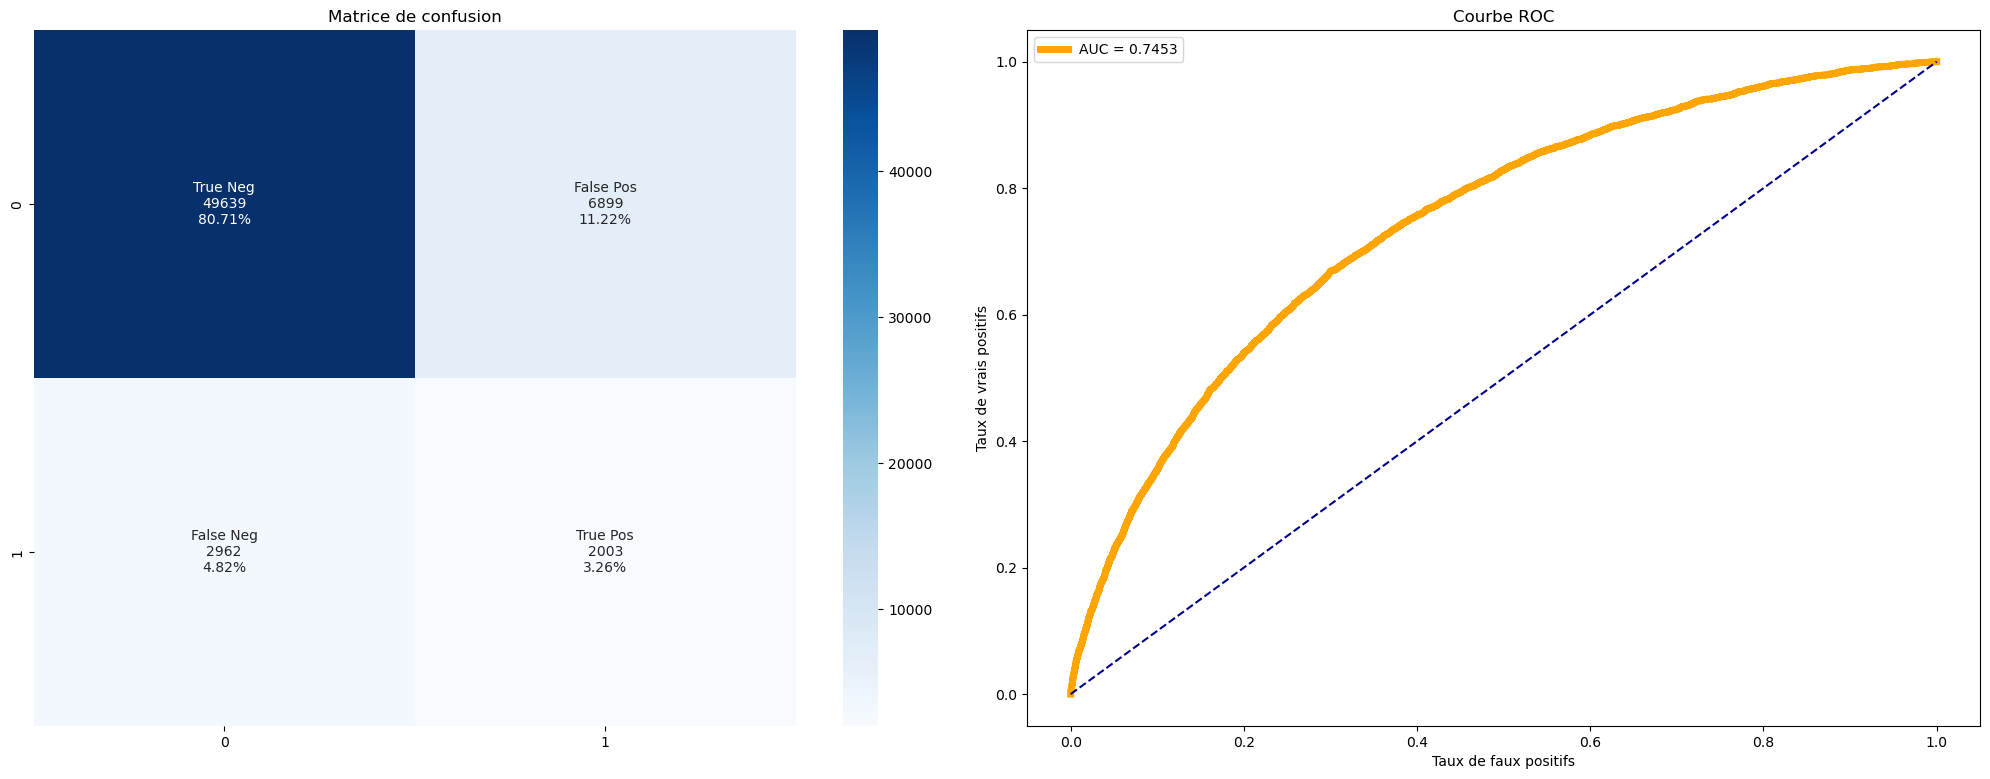

In [33]:
confusion_matrix_roc_auc(rfc_opt_30, y_test, y_pred_custom_threshold_rfc_opt_30, rfc_opt_30.predict_proba(X_test_scaled)[:,1])

**A NOTER: Ce modèle ne servant que pour la gestion du déséquilibre des classes est déjà prometteur.**

## GESTION DU DESEQUILIBRE DES CLASSES

**Dans notre jeu de données, nous avons un problème de déséquilibre des classes avec 91,9% de clients sans risque et 8,1% de clients à risque, ce qui est très mauvais pour la modélisation. En effet, lorsque les classes ne sont pas représentées de façon relativement équilibrées, les modèles ont tendance à privilégier la classe majoritaire, ce qui peut entraîner de faibles performances sur la classe minoritaire. Par conséquent, il est indispensable de ré-équilibrer les classes, ce qui peut se faire globlablement soit par un ré-échantillonnage de classes, soit en attribuant des poids différents aux classes (class_weight). Lors des Random Forest Classifier réalisés, la gestion du déséquilibre des classes avait été géré avec le paramètre class_weight="balanced".**

**Dans cette partie, nous aborderons différentes méthodes pour gérer le déséquilibre des classes:**
- **SMOTE (Synthetic Minority Over-sampling Technique)**: Création d'échantillons synthétiques dans la classe minoritaire en se basant sur les k plus proches voisins, aboutissant au même nombre d'échantillons dans les 2 classes.
- **OVERSAMPLING:**: Recherche du bon équilibre en augmentant le nombre d'observations de la classe minoritaire afin d'arriver à un ratio classe minoritaire/ classe majoritaire satisfaisant.
- **UNDERSAMPLING:** Recherche du bon équilibre en diminuant le nombre d'observations de la classe majoritaire afin d'arriver à un ratio classe minoritaire/ classe majoritaire satisfaisant.
- **Le CLASS_WEIGHT 'maison'**: Attribution de différents poids à la classe minoritaire afin de trouver la meilleure gestion du déséquilibre des classes.

**A NOTER:** Pour cette partie, le class_weight="balanced" du random Forest sera éliminée.

## 1. SMOTE (Synthetic Minority Over-sampling Technique)

In [34]:
smote_30f = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rfc', RandomForestClassifier(random_state=42, max_depth=16, max_features='log2', min_samples_leaf=1, n_estimators=400))])

smote_model = []
smote_model.append(("SMOTE", smote_30f))

In [35]:
# Création du dictionnaire pour le stockage des métriques de chaque modèle
metrics_dict = {}

for model_name, model in smote_model:
    smote_results = mlflow_tracking(model, X_train_scaled, X_test_scaled, y_train, y_test, thresholds=np.linspace(0, 1, 100))
    metrics_dict[model_name] = smote_results

# Création du dataframe global par concaténation des dataframes individuels en colonnes
smote_results = pd.concat(metrics_dict.values(), axis=1, keys=metrics_dict.keys())

# Elimination des 0 dans le nom des colonnes 
smote_results.columns = [col[0].replace('0', '') for col in smote_results.columns]

## 2. Le sur-échantillonnage et le sous-échantillonnage

In [36]:
# Modèles avec pipelines
over_rfc = Pipeline([('over', RandomOverSampler(sampling_strategy='auto', random_state=42)), 
                     ('rfc', RandomForestClassifier(random_state=42, max_depth=16, max_features='log2', min_samples_leaf=1, n_estimators=400))])
                    
under_rfc= Pipeline([('under', RandomUnderSampler(sampling_strategy='auto', random_state=42)), 
                     ('rfc', RandomForestClassifier(random_state=42, max_depth=16, max_features='log2', min_samples_leaf=1, n_estimators=400))])
                
under_over_models = [] 
under_over_models.append(("RFC oversampling", over_rfc))
under_over_models.append(("RFC undersampling", under_rfc))                                        

In [37]:
# Création du dictionnaire pour le stockage des métriques de chaque modèle
metrics_dict = {}

for model_name, model in under_over_models:
    under_over_results = mlflow_tracking(model, X_train_scaled, X_test_scaled, y_train, y_test, thresholds=np.linspace(0, 1, 100))
    metrics_dict[model_name] = under_over_results

# Création du dataframe global par concaténation des dataframes individuels en colonnes
under_over_results = pd.concat(metrics_dict.values(), axis=1, keys=metrics_dict.keys())

# Elimination des 0 dans le nom des colonnes 
under_over_results.columns = [col[0].replace('0', '') for col in under_over_results.columns]

combined_smote = pd.concat([smote_results, under_over_results], axis=1)
combined_smote

,SMOTE,RFC oversampling,RFC undersampling
Model,Pipeline,Pipeline,Pipeline
Training Time,788.2608,471.5283,49.6051
Train Accuracy,82.1311,94.366,86.5476
Test Accuracy,75.889,87.4673,82.0805
Train AUC,0.9171,0.9891,0.9489
Test AUC,0.715,0.7477,0.7506
Train Recall,0.9037,0.9695,0.9046
Test Recall,0.5106,0.3072,0.4699
Train Precision,0.2992,0.5923,0.3654
Test Precision,0.1697,0.2632,0.2176


**Parmi ces 3 méthodes, SMOTE est la technique la moins prometteuse pour la gestion du déséquilibre des classes toutes métriques confondues, alors que l'undersampling (sous-échantillonnage) serait plus intéressante non seulement au niveau de NOTRE METRIQUE mais aussi en terme d'overfitting.**

**Néanmoins trouvant dommage de perdre des données (ou d'en créer par sur-échantillonnage), je souhaiterais plutôt attribuer des poids différents à nos 2 classes. C'est pourquoi, différents poids seront testés.**

## 3. L'attribution de poids différents aux 2 classes

**L'attribution de poids différents entre les 2 classes peut également permettre la gestion de classes déséquilibrées. La plupart des algorithmes possède un hyperparamètre dédié au déséquilibre des classes. Néanmoins, il est préférable de trouver le bon équilibre en testant diverses combinaisons. Pour cela, 6 poids différents seront attribués à la classe minoritaire.**

**RAPPEL: Le Random Forest Classifier utilisé lors de la RFE-CV prenait en compte ce paramètre (class_weight="balanced").**

In [38]:
# Listes des modèles testés
weight_rfc_2 = RandomForestClassifier(max_depth = 16, max_features = 'log2', n_estimators = 400, min_samples_leaf = 1, class_weight={0:1, 1:2}, random_state=42, n_jobs=-1)
weight_rfc_4 = RandomForestClassifier(max_depth = 16, max_features = 'log2', n_estimators = 400, min_samples_leaf = 1, class_weight={0:1, 1:4}, random_state=42, n_jobs=-1)
weight_rfc_6 = RandomForestClassifier(max_depth = 16, max_features = 'log2', n_estimators = 400, min_samples_leaf = 1, class_weight={0:1, 1:6}, random_state=42, n_jobs=-1)
weight_rfc_8 = RandomForestClassifier(max_depth = 16, max_features = 'log2', n_estimators = 400, min_samples_leaf = 1, class_weight={0:1, 1:8}, random_state=42, n_jobs=-1)
weight_rfc_10 = RandomForestClassifier(max_depth = 16, max_features = 'log2', n_estimators = 400, min_samples_leaf = 1, class_weight={0:1, 1:10}, random_state=42, n_jobs=-1)
weight_rfc_12 = RandomForestClassifier(max_depth = 16, max_features = 'log2', n_estimators = 400, min_samples_leaf = 1, class_weight={0:1, 1:12}, random_state=42, n_jobs=-1)

weight_models = []
weight_models.append(("RFC weight 2", weight_rfc_2))
weight_models.append(("RFC weight 4", weight_rfc_4))
weight_models.append(("RFC weight 6", weight_rfc_6))
weight_models.append(("RFC weight 8", weight_rfc_8))
weight_models.append(("RFC weight 1O", weight_rfc_10))
weight_models.append(("RFC weight 12", weight_rfc_12))

In [39]:
# Création du dictionnaire pour le stockage des métriques de chaque modèle
metrics_dict = {}

for model_name, model in weight_models:
    weight_results = mlflow_tracking(model, X_train_scaled, X_test_scaled, y_train, y_test, thresholds=np.linspace(0, 1, 100))
    metrics_dict[model_name] = weight_results

# Création du dataframe global par concaténation des dataframes individuels en colonnes
weight_results = pd.concat(metrics_dict.values(), axis=1, keys=metrics_dict.keys())

# Elimination des 0 dans le nom des colonnes 
weight_results.columns = [col[0].replace('0', '') for col in weight_results.columns]

combined_final_results = pd.concat([combined_smote, weight_results], axis=1)
combined_final_results

,SMOTE,RFC oversampling,RFC undersampling,RFC weight 2,RFC weight 4,RFC weight 6,RFC weight 8,RFC weight 1O,RFC weight 12
Model,Pipeline,Pipeline,Pipeline,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier
Training Time,788.2608,471.5283,49.6051,76.5559,79.1562,78.189,78.2867,78.0988,75.2507
Train Accuracy,82.1311,94.366,86.5476,94.6876,94.39,92.8949,92.3974,91.1446,90.5332
Test Accuracy,75.889,87.4673,82.0805,85.934,86.8185,85.8755,85.669,84.7016,84.3016
Train AUC,0.9171,0.9891,0.9489,0.9896,0.9871,0.9831,0.9789,0.9734,0.9688
Test AUC,0.715,0.7477,0.7506,0.7516,0.7524,0.7496,0.7478,0.7459,0.7444
Train Recall,0.9037,0.9695,0.9046,0.9526,0.9549,0.9668,0.9654,0.9679,0.9666
Test Recall,0.5106,0.3072,0.4699,0.3811,0.3372,0.3623,0.3635,0.3907,0.3966
Train Precision,0.2992,0.5923,0.3654,0.6094,0.5951,0.5331,0.5156,0.4762,0.459
Test Precision,0.1697,0.2632,0.2176,0.2533,0.2579,0.2458,0.242,0.2331,0.2282


**En se basant essentiellement sur NOTRE METRIQUE METIER mais en tenant également compte des autres métriques, les 2 modèles les plus intéressants sont:**
- **L'attribution des poids {0:1, 1:2}**: Meilleurs scores métiers sur les jeux d'entraînement et de test après seuillage.
- **L'attribution des poids {0:1, 1:4}**: Très bons scores métiers sur les jeux d'entraînement et de test après seuillage et très légèrement moins d'overfitting. 

**Une analyse de ces 2 modèles sera donc réalisée pour sélectionner la meilleure option pour la gestion du déséquilibre des classes.**

**A NOTER: L'undersampling offrait aussi des résultats satisfaisants sur notre métrique, mais je ne souhaite pas perdre de données. De ce fait, ce modèle ne sera pas analysé.**

## 4. Analyse des 2 modèles

### 4.1 L'attribution des poids {0:1, 1:2}

In [40]:
weight_rfc_2 = RandomForestClassifier(max_depth = 16, max_features = 'log2', n_estimators = 400, min_samples_leaf = 1, class_weight= {0:1, 1:2}, random_state=42, n_jobs=-1)
weight_rfc_2.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=16,
                       max_features='log2', n_estimators=400, n_jobs=-1,
                       random_state=42)

In [41]:
# Recherche du meilleur seuil
thresholds = [i/100 for i in range(0, 101)]
best_threshold_weight_rfc_2, best_score_threshold_weight_rfc_2, scores_weight_rfc_2 = seuil_metier(weight_rfc_2, X_train_scaled, y_train, thresholds)
print(f"Best Threshold: {best_threshold_weight_rfc_2}, Best Score: {best_score_threshold_weight_rfc_2}")

Best Threshold: 0.21, Best Score: 0.08495993829395375


In [42]:
# Prédiction et probabilité pour la classe positive
y_probs_weight_rfc_2 = weight_rfc_2.predict_proba(X_test_scaled)[:, 1]  

# Application du seuil
y_pred_custom_threshold_weight_rfc_2 = [1 if prob > best_threshold_weight_rfc_2 else 0 for prob in y_probs_weight_rfc_2]

print(classification_report(y_test, y_pred_custom_threshold_weight_rfc_2))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     56538
           1       0.25      0.39      0.30      4965

    accuracy                           0.86     61503
   macro avg       0.60      0.64      0.61     61503
weighted avg       0.89      0.86      0.87     61503



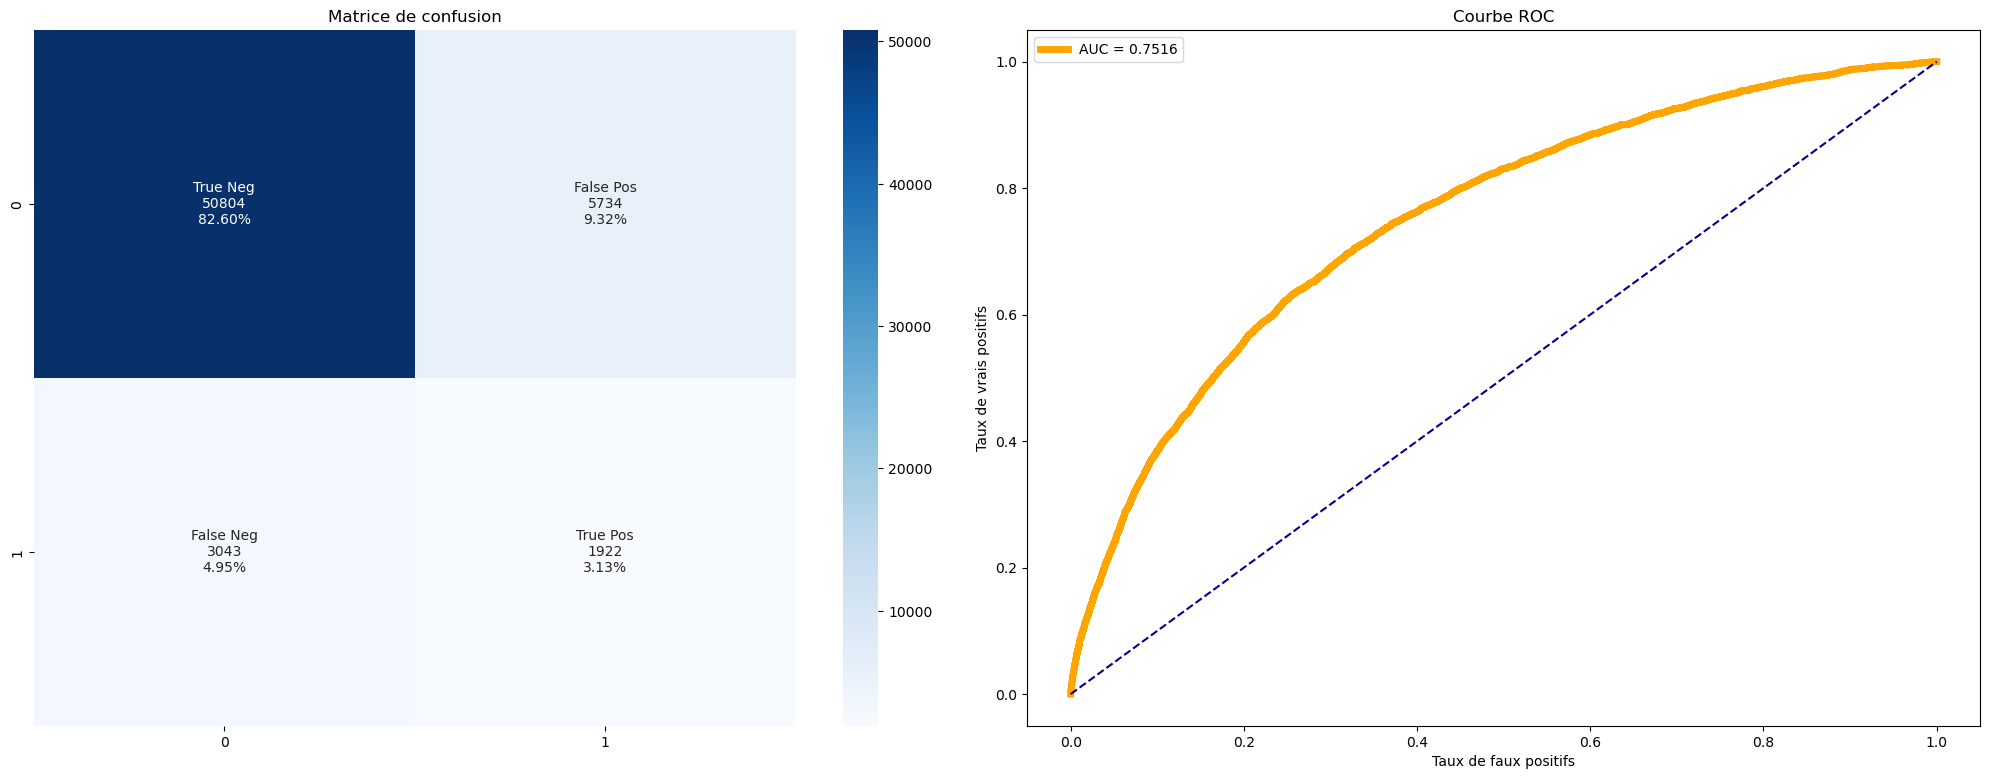

In [43]:
confusion_matrix_roc_auc(weight_rfc_2, y_test, y_pred_custom_threshold_weight_rfc_2, weight_rfc_2.predict_proba(X_test_scaled)[:,1])

### 4.2. L'attribution des poids {0:1, 1:4}

In [44]:
weight_rfc_4 = RandomForestClassifier(max_depth = 16, max_features = 'log2', n_estimators = 400, min_samples_leaf = 1, class_weight= {0:1, 1:4}, random_state=42, n_jobs=-1)
weight_rfc_4.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=16,
                       max_features='log2', n_estimators=400, n_jobs=-1,
                       random_state=42)

In [45]:
# Recherche du meilleur seuil
thresholds = [i/100 for i in range(0, 101)]
best_threshold_weight_rfc_4, best_score_threshold_weight_rfc_4, scores_weight_rfc_4 = seuil_metier(weight_rfc_4, X_train_scaled, y_train, thresholds)
print(f"Best Threshold: {best_threshold_weight_rfc_4}, Best Score: {best_score_threshold_weight_rfc_4}")

Best Threshold: 0.31, Best Score: 0.08603443585366143


In [46]:
# Prédiction et probabilité pour la classe positive
y_probs_weight_rfc_4 = weight_rfc_4.predict_proba(X_test_scaled)[:, 1]  

# Application du seuil
y_pred_custom_threshold_weight_rfc_4 = [1 if prob > best_threshold_weight_rfc_4 else 0 for prob in y_probs_weight_rfc_4]

print(classification_report(y_test, y_pred_custom_threshold_weight_rfc_4))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     56538
           1       0.26      0.34      0.29      4965

    accuracy                           0.87     61503
   macro avg       0.60      0.63      0.61     61503
weighted avg       0.89      0.87      0.88     61503



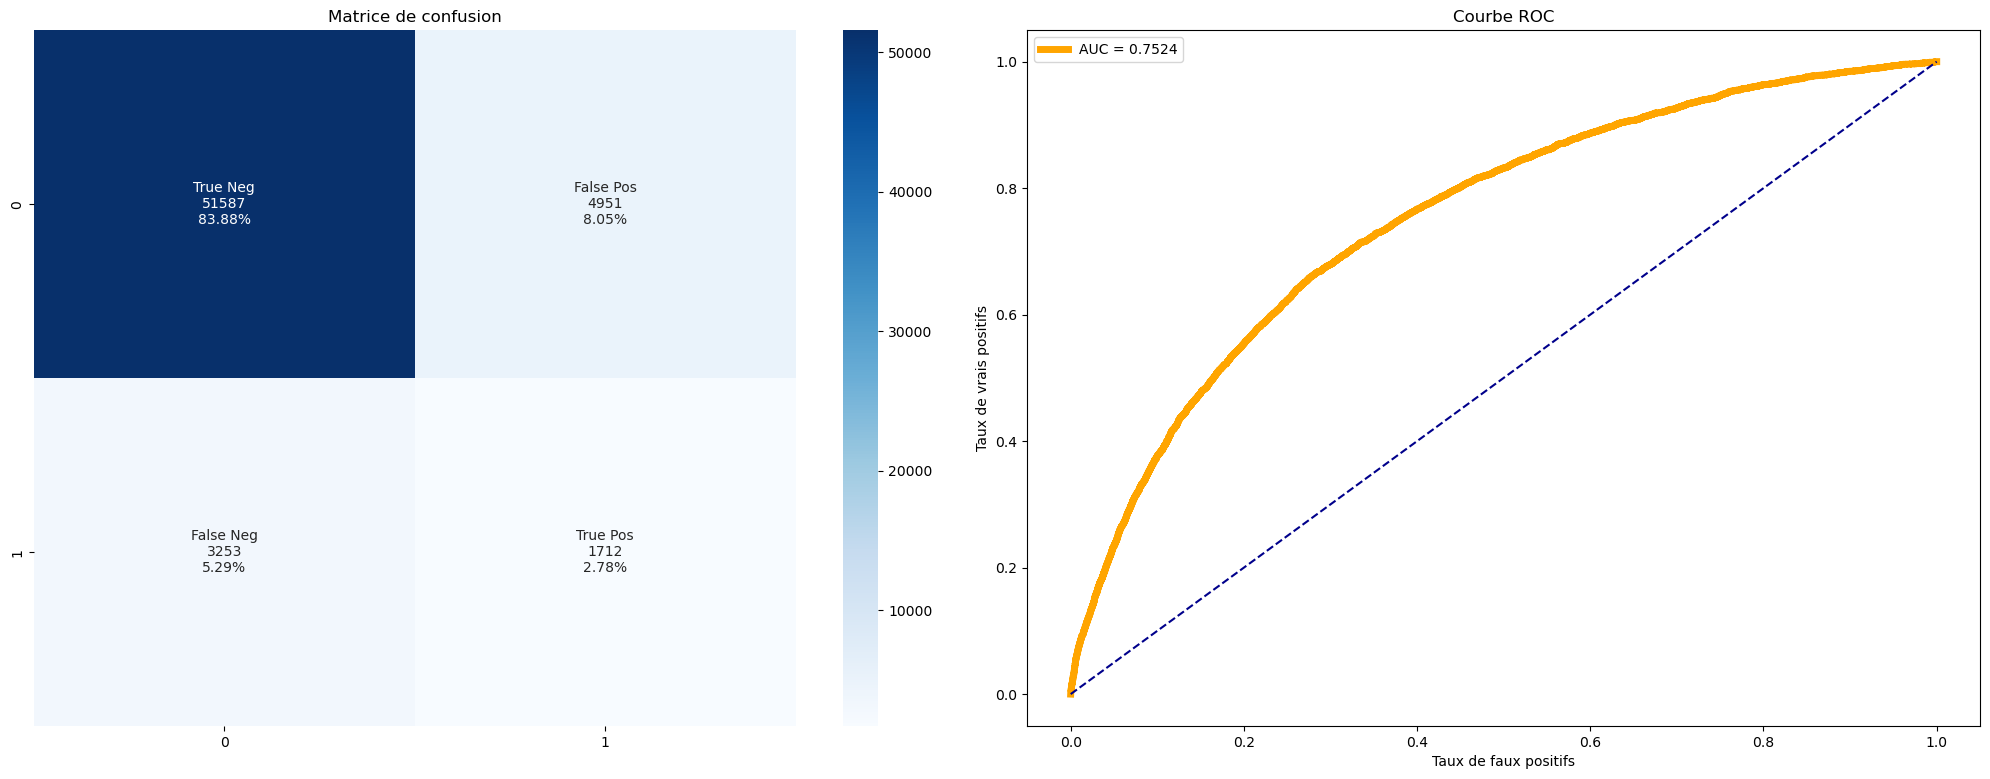

In [47]:
confusion_matrix_roc_auc(weight_rfc_4, y_test, y_pred_custom_threshold_weight_rfc_4, weight_rfc_4.predict_proba(X_test_scaled)[:,1])

### CHOIX POUR LA GESTION DU DESEQUILIBRE DES CLASSES: Le class_weight = {0:1, 1:2}
- **Métriques métiers prioritaires**
- **Moins de faux positifs et plus de vrais positifs**

**Ce notebook sera sauvegardé sous le nom de 'Ple_Coline_5_notebook_imbalanced_092023' dans les livrables et 'notebook_5_rfecv_imbalanced' sur GitHub.**